This notebook tries to extend the results from the adversarial spheres paper: https://arxiv.org/pdf/1801.02774.pdf

In particular, instead of generating from spheres, we generate from Gaussians
(with the hope that the high dimensionality makes them effectively spheres).

This is an iteration on top of gaussian-v1.ipynb.
Unlike the first notebook,
we focus on the norm $O(1)$ regime in this notebook,
since this is where the vanilla NN performs the best.
The plan is to also study the NTK of this vanilla NN in the future.

Greg Yang's framework can also compute NTK even with batchnorm?

We also provide visualizations of what the network is doing at different radii.

### Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from art.data_generators import TensorFlowV2DataGenerator
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent
from art.defences.trainer import AdversarialTrainer

tf.config.list_physical_devices(device_type=None)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data generation

Our data in labeled by $Y \in \{0, 1\}$,
and $X | Y \sim \mathcal{N}(0, \sigma_Y \cdot I_d)$.

In [2]:
def generate_normal_data(dim, s0, s1, num_samples):
    assert num_samples % 2 == 0
    assert s0 <= s1
    
    ys = np.concatenate([
        np.zeros(shape=num_samples // 2, dtype=np.int64),
        np.ones(shape=num_samples // 2, dtype=np.int64)
    ])
    
    xs = np.concatenate([
        np.random.normal(scale=s0, size=(num_samples // 2, dim)),
        np.random.normal(scale=s1, size=(num_samples // 2, dim))
    ])
    
    perm = np.random.permutation(num_samples)
    xs = xs[perm]
    ys = ys[perm]
    
    return xs, ys

def normalize(xs: np.ndarray, norm):
    norm_xs = xs / np.linalg.norm(xs, axis=-1, ord=norm).reshape(-1, 1)
    return norm_xs

def radial_attack(
    xs: np.ndarray, ys: np.ndarray,
    attack_norm, attack_eps,
):
    norm_xs = normalize(xs, norm=attack_norm)
    
    adv_xs = xs.copy()
    adv_xs[ys == 0] += attack_eps * norm_xs[ys == 0]
    adv_xs[ys == 1] -= attack_eps * norm_xs[ys == 1]
    
    return adv_xs

xs, ys = generate_normal_data(dim=2, s0=0.3, s1=0.7, num_samples=4)
radial_attack(xs=xs, ys=ys, attack_norm=2, attack_eps=0.1)

array([[ 0.81466013,  0.34927357],
       [ 0.32084145, -0.90376197],
       [ 0.12104539, -0.17028484],
       [ 0.25464725, -0.06052978]])

# Theoretically optimal classifier

(0.9864, 0.9564)

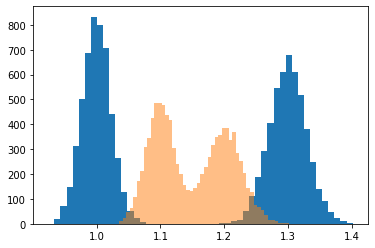

In [3]:
def opt_classifier(xs, thresh=1.15):
    return (np.linalg.norm(xs, ord=2, axis=-1) >= thresh).astype(int)

xs, ys = generate_normal_data(dim=1000, s0=1.0 / np.sqrt(1000), s1=1.3 / np.sqrt(1000), num_samples=10 ** 4)
plt.hist(np.linalg.norm(xs, ord=2, axis=-1), bins=50);

xs_adv_rad = radial_attack(xs=xs, ys=ys, attack_norm=2, attack_eps=0.1)
plt.hist(np.linalg.norm(xs_adv_rad, ord=2, axis=-1), bins=50, alpha=0.5);

(opt_classifier(xs_adv_rad[ys == 0]) == 0).mean(), (opt_classifier(xs_adv_rad[ys == 1]) == 1).mean()

# One-hidden layer ReLU-NN can achieve high nat. acc.
Our hidden network $f: \mathbb{R}^d \to \{0, 1\}$ behaves as
$$
f(x) = \mathbb{1}\left( \frac{1^\top (x)^+ - 1^\top (-x)^+}{d} \geq r \times \sqrt{\frac{2}{\pi}} \right)
     = \mathbb{1}\left( \frac{1^\top |x| }{d} \geq r \times \sqrt{\frac{2}{\pi}} \right),
$$
where to maximize natural accuracy we want $r = \frac{\sigma_0 + \sigma_1}{2}$.

Why does the threshold take that value?

Well if $X \sim \mathcal{N}(0, \sigma^2)$ then as $d \to \infty$ it holds that

$$
\frac{1^\top |X| }{d} \overset{d}{\longrightarrow}
\mathcal{N}\left( \sigma \sqrt{\frac{2}{\pi}}, \frac{\sigma^2}{d} \left(1 - \frac{2}{\pi}\right) \right).
$$

See https://en.wikipedia.org/wiki/Folded_normal_distribution for details.

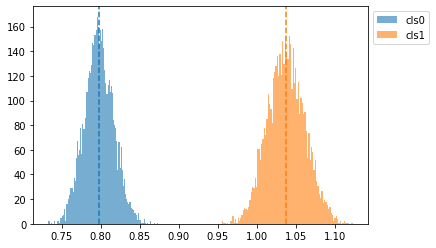

In [4]:
xs, ys = generate_normal_data(dim=1000, s0=1.0, s1=1.3, num_samples=10 ** 4)
plt.hist(np.abs(xs[ys == 0]).mean(axis=-1), bins=100, alpha=0.6, label="cls0");
plt.hist(np.abs(xs[ys == 1]).mean(axis=-1), bins=100, alpha=0.6, label="cls1");

plt.axvline(np.sqrt(2 / np.pi), color="C0", ls="--");
plt.axvline(1.3 * np.sqrt(2 / np.pi), color="C1", ls="--");
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

In [5]:
def simple_nn_classifier(xs, thresh=1.15 * np.sqrt(2 / np.pi)):
    return (
        np.abs(xs).mean(axis=-1) >= thresh
    ).astype(int)

(simple_nn_classifier(xs[ys == 0]) == 0).mean(), (simple_nn_classifier(xs[ys == 1]) == 1).mean()

(1.0, 1.0)

### Robustness of simple classifier
This simple classifier has okay robustness as well.

Say we had a $\ell_2$ perturbation budget of $\epsilon = O(\sigma\sqrt{d})$
(this is size of adversarial in practice).
To maximize the change to $f$ (WLOG say from class 0 to class 1),
we would want to make the pertubation $\frac{\epsilon}{\sqrt{d}} 1_d$.

This perturbation would cause $\frac{1^\top |x| }{d}$ to change by
$\epsilon / \sqrt{d} = O(\sigma)$.
Asymptotically, this is the best level of robustness we could hope for.

What follows are some empirical results.

In [6]:
xs_adv_rad = radial_attack(xs=xs, ys=ys, attack_norm=2, attack_eps=0.1 * np.sqrt(1000))
(simple_nn_classifier(xs_adv_rad[ys == 0]) == 0).mean(), (simple_nn_classifier(xs_adv_rad[ys == 1]) == 1).mean()

(0.9794, 0.9596)

In [7]:
def simple_classifier_attack(xs: np.ndarray, ys: np.ndarray, attack_eps: float):
    d = xs.shape[-1]
    xs_adv = xs.copy()
    
    xs_adv[ys == 0] += attack_eps / np.sqrt(d) * np.sign(xs_adv[ys == 0])
    xs_adv[ys == 1] -= attack_eps / np.sqrt(d) * np.sign(xs_adv[ys == 1])
    
    return xs_adv
    
xs_adv_simpl = simple_classifier_attack(xs=xs, ys=ys, attack_eps=0.1 * np.sqrt(1000))
(simple_nn_classifier(xs_adv_simpl[ys == 0]) == 0).mean(), (simple_nn_classifier(xs_adv_simpl[ys == 1]) == 1).mean()

(0.8562, 0.8616)

To improve this simple ReLU-NN classifier,
instead of using the absolute value function we could compose more ReLUs to approximate the $x^2$ function.
This could still be done using only 1 hidden-layer.

# Experiments with larger NNs

### Experiment utility code

In [8]:
def eval_model(
    model: tf.keras.Model,
    xs: np.ndarray,
    ys: np.ndarray,
    verbose=0,
):
    """Returns accuracies per class"""
    _, acc0 = model.evaluate(xs[ys == 0], ys[ys == 0], verbose=verbose)
    _, acc1 = model.evaluate(xs[ys == 1], ys[ys == 1], verbose=verbose)
    return acc0, acc1

def fmt_accs(accs):
    return "(" + ", ".join(f"{a:.4f}" for a in accs) + ")"

fmt_accs([1,2])

'(1.0000, 2.0000)'

In [9]:
def run_experiment_v2(
    dim, s0, s1,
    num_train,
    model_layers,
    train_epochs,
    attack_norm,
    attack_eps,
    attack_eps_step,
    attack_iters,
    train_batch_size=64,
    learning_rate=3e-4,
    attack_batch_size=256,
    num_test=4096,
    seed=42,
    adv_train=False,
    adv_train_log_interval=2, # measured in epochs
):
    """
    Default values for num_train and num_test are size of CIFAR10 dataset.
    
    Keras code derived from https://keras.io/examples/vision/mnist_convnet/.
    
    ART code derived from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_retraining.ipynb
    and https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/238.
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    x_train, y_train = generate_normal_data(
        dim=dim, s0=s0, s1=s1,
        num_samples=num_train,
    )

    x_test, y_test = generate_normal_data(
        dim=dim, s0=s0, s1=s1,
        num_samples=num_test,
    )
    
    model = keras.Sequential(
        [keras.layers.InputLayer(input_shape=x_train[0].shape)]
        + model_layers
    )
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["accuracy"]
    )
    
    # Wrapper around tf.keras.Model.train_step
    # Used for compatibility with art.estimators.classification.TensorFlowV2Classifier
    _sample_count = 0
    art_pgd_attack = None # Forward declaration. Hacky...
    def train_step(model, images, labels):
        nonlocal _sample_count
        nonlocal art_pgd_attack
        
        out = model.train_step((images, labels))
        
        old_sample_count = _sample_count
        _sample_count += images.shape[0]
        
        old_epoch = old_sample_count // num_train
        cur_epoch = _sample_count // num_train
        
        if old_epoch < cur_epoch:
            if old_epoch % adv_train_log_interval == 0:
                x_val = art_pgd_attack.generate(x_test, y=y_test)
                val_accs = eval_model(model, x_val, y_test)
                
                loss = float(out["loss"])
                acc = float(out["accuracy"])
                print(f"Finished epoch {old_epoch}; acc={acc:.4f}; val_accs={fmt_accs(val_accs)}; loss={loss}")
                
            model.reset_metrics()
    
    art_model = TensorFlowV2Classifier(
        model=model,
        input_shape=x_test[0].shape,
        nb_classes=2,
        clip_values=None, #[-x_test.max(), x_test.max()],
        loss_object=model.loss,
        train_step=train_step,
    )
    art_pgd_attack = ProjectedGradientDescent(
        art_model,
        norm=attack_norm,
        eps=attack_eps,
        eps_step=attack_eps_step,
        max_iter=attack_iters,
        batch_size=attack_batch_size,
    )
    
    try: # Catch keyboard interrupt so we can exit training early
        if adv_train:
            adv_trainer = AdversarialTrainer(art_model, attacks=art_pgd_attack, ratio=1.0)
            adv_trainer.fit(x=x_train, y=y_train, batch_size=train_batch_size, nb_epochs=train_epochs)
        else:
            model.fit(
                x_train,
                y_train,
                batch_size=train_batch_size,
                epochs=train_epochs,
                validation_data=(x_test, y_test),
                verbose=2,
            )
    except KeyboardInterrupt:
        pass

    model.trainable = False
    
    x_train_adv_pgd = art_pgd_attack.generate(x_train[:num_test], y=y_train[:num_test])    
    x_test_adv_pgd = art_pgd_attack.generate(x_test, y=y_test)
    
    x_train_adv_rad = radial_attack(xs=x_train[:num_test], ys=y_train[:num_test],
                                    attack_norm=attack_norm, attack_eps=attack_eps)
    x_test_adv_rad = radial_attack(xs=x_test, ys=y_test,
                                   attack_norm=attack_norm, attack_eps=attack_eps)
    
    nat_train_accs = eval_model(model, x_train, y_train)
    nat_test_accs = eval_model(model, x_test, y_test)
    adv_pgd_train_accs = eval_model(model, x_train_adv_pgd, y_train[:num_test])
    adv_pgd_test_accs = eval_model(model, x_test_adv_pgd, y_test)
    adv_rad_train_accs = eval_model(model, x_train_adv_rad, y_train[:num_test])
    adv_rad_test_accs = eval_model(model, x_test_adv_rad, y_test)
    
    print("Nat train accs     :", fmt_accs(nat_train_accs))
    print("Nat test  accs     :", fmt_accs(nat_test_accs))
    print("Adv-pgd train accs :", fmt_accs(adv_pgd_train_accs))
    print("Adv-pgd test  accs :", fmt_accs(adv_pgd_test_accs))
    print("Adv-rad train accs :", fmt_accs(adv_rad_train_accs))
    print("Adv-rad test  accs :", fmt_accs(adv_rad_test_accs))
    
    return dict(
        model=model,
        train_data=(x_train, y_train),
        test_data=(x_test, y_test),
        x_train_adv_pgd=x_train_adv_pgd,
        x_test_adv_pgd=x_test_adv_pgd,
        x_train_adv_rad=x_train_adv_rad,
        x_test_adv_rad=x_test_adv_rad,
    )

In [10]:
def cls1_frac_by_rad(
    model: tf.keras.Model,
    rads: np.ndarray,
    num_samples_per_rad=256,
    batch_size=64,
):
    dim = model.input_shape[-1]
    
    cls1_fracs = np.zeros_like(rads)
    for idx, r in enumerate(tqdm(rads, leave=False)):
        xs = r * normalize(
            xs=np.random.normal(size=(num_samples_per_rad, dim)),
            norm=2
        )

        pred_probs = model.predict(xs, batch_size=batch_size)
        preds = np.argmax(pred_probs, axis=-1)
        
        cls1_fracs[idx] = (preds == 1).mean()
        
    return cls1_fracs

## Begin experiments

Norm $O(1)$, natural training, dim=1000, depth=2, width=1000

In [11]:
%%time
D = 1000
res = run_experiment_v2(
    dim=D, s0=1.0 / np.sqrt(D), s1=1.3 / np.sqrt(D),
    num_train=10 ** 4,
    learning_rate=3e-4,
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=128,
    train_epochs=10,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
)

Epoch 1/10
79/79 - 2s - loss: 0.6423 - accuracy: 0.6062 - val_loss: 0.5435 - val_accuracy: 0.7595
Epoch 2/10
79/79 - 1s - loss: 0.2798 - accuracy: 0.9433 - val_loss: 0.2042 - val_accuracy: 0.9551
Epoch 3/10
79/79 - 1s - loss: 0.0310 - accuracy: 0.9998 - val_loss: 0.1085 - val_accuracy: 0.9780
Epoch 4/10
79/79 - 1s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0959 - val_accuracy: 0.9766
Epoch 5/10
79/79 - 1s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0881 - val_accuracy: 0.9753
Epoch 6/10
79/79 - 1s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0853 - val_accuracy: 0.9751
Epoch 7/10
79/79 - 1s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0804 - val_accuracy: 0.9753
Epoch 8/10
79/79 - 1s - loss: 8.8883e-04 - accuracy: 1.0000 - val_loss: 0.0779 - val_accuracy: 0.9753
Epoch 9/10
79/79 - 1s - loss: 6.6103e-04 - accuracy: 1.0000 - val_loss: 0.0759 - val_accuracy: 0.9753
Epoch 10/10
79/79 - 1s - loss: 5.0617e-04 - accuracy: 1.0000 - val_loss: 0.0723 - val_accuracy: 0.9766


PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train accs     : (1.0000, 1.0000)
Nat test  accs     : (0.9990, 0.9541)
Adv-pgd train accs : (0.6229, 0.6081)
Adv-pgd test  accs : (0.1235, 0.0894)
Adv-rad train accs : (1.0000, 1.0000)
Adv-rad test  accs : (0.8555, 0.6655)
CPU times: user 14.9 s, sys: 7.59 s, total: 22.5 s
Wall time: 23.9 s


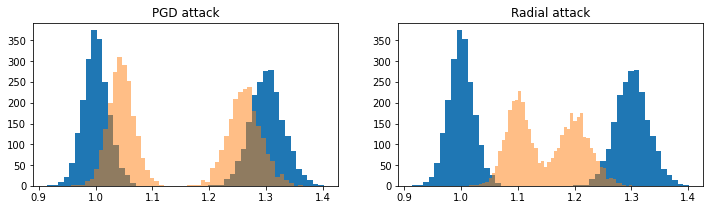

In [12]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_pgd"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"PGD attack");

plt.subplot(1, 2, 2)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_rad"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"Radial attack");

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

CPU times: user 8.37 s, sys: 662 ms, total: 9.03 s
Wall time: 8.44 s


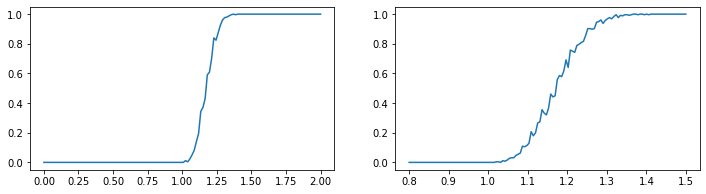

In [13]:
%%time
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
rads = np.linspace(start=0, stop=2, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

plt.subplot(1, 2, 2)
rads = np.linspace(start=0.8, stop=1.5, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

---

Norm $O(1)$, natural training, dim=1000, depth=2, width=5000

In [14]:
%%time
D = 1000
res = run_experiment_v2(
    dim=D, s0=1.0 / np.sqrt(D), s1=1.3 / np.sqrt(D),
    num_train=10 ** 4,
    learning_rate=3e-4,
    model_layers=[
        layers.Dense(5000, activation="relu"),
        layers.Dense(5000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=128,
    train_epochs=10,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
)

Epoch 1/10
79/79 - 1s - loss: 0.5294 - accuracy: 0.7170 - val_loss: 0.2337 - val_accuracy: 0.9312
Epoch 2/10
79/79 - 1s - loss: 0.0393 - accuracy: 0.9961 - val_loss: 0.0450 - val_accuracy: 0.9963
Epoch 3/10
79/79 - 1s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0285 - val_accuracy: 0.9971
Epoch 4/10
79/79 - 1s - loss: 7.5258e-04 - accuracy: 1.0000 - val_loss: 0.0281 - val_accuracy: 0.9963
Epoch 5/10
79/79 - 1s - loss: 4.5816e-04 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 0.9971
Epoch 6/10
79/79 - 1s - loss: 3.1375e-04 - accuracy: 1.0000 - val_loss: 0.0246 - val_accuracy: 0.9971
Epoch 7/10
79/79 - 1s - loss: 2.2893e-04 - accuracy: 1.0000 - val_loss: 0.0229 - val_accuracy: 0.9971
Epoch 8/10
79/79 - 1s - loss: 1.7404e-04 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 0.9971
Epoch 9/10
79/79 - 1s - loss: 1.3638e-04 - accuracy: 1.0000 - val_loss: 0.0217 - val_accuracy: 0.9968
Epoch 10/10
79/79 - 1s - loss: 1.0932e-04 - accuracy: 1.0000 - val_loss: 0.0212 - val_accuracy

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train accs     : (1.0000, 1.0000)
Nat test  accs     : (1.0000, 0.9927)
Adv-pgd train accs : (0.9995, 0.9995)
Adv-pgd test  accs : (0.4062, 0.2681)
Adv-rad train accs : (1.0000, 1.0000)
Adv-rad test  accs : (0.9106, 0.7271)
CPU times: user 14.2 s, sys: 6.02 s, total: 20.2 s
Wall time: 21 s


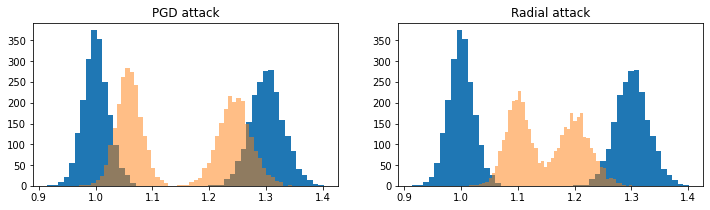

In [15]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_pgd"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"PGD attack");

plt.subplot(1, 2, 2)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_rad"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"Radial attack");

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

CPU times: user 8.28 s, sys: 424 ms, total: 8.7 s
Wall time: 8.12 s


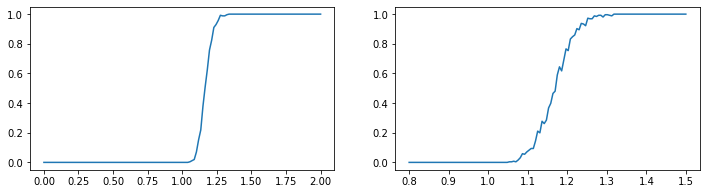

In [16]:
%%time
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
rads = np.linspace(start=0, stop=2, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

plt.subplot(1, 2, 2)
rads = np.linspace(start=0.8, stop=1.5, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

---

Norm $O(1)$, natural training, dim=1000, depth=2, width=10000

In [11]:
%%time
D = 1000
res = run_experiment_v2(
    dim=D, s0=1.0 / np.sqrt(D), s1=1.3 / np.sqrt(D),
    num_train=10 ** 4,
    learning_rate=3e-4,
    model_layers=[
        layers.Dense(10000, activation="relu"),
        layers.Dense(10000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=128,
    train_epochs=10,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
)

Epoch 1/10
79/79 - 2s - loss: 0.5442 - accuracy: 0.6981 - val_loss: 0.2382 - val_accuracy: 0.9172
Epoch 2/10
79/79 - 1s - loss: 0.0396 - accuracy: 0.9922 - val_loss: 0.0507 - val_accuracy: 0.9900
Epoch 3/10
79/79 - 1s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0326 - val_accuracy: 0.9937
Epoch 4/10
79/79 - 1s - loss: 4.1630e-04 - accuracy: 1.0000 - val_loss: 0.0290 - val_accuracy: 0.9944
Epoch 5/10
79/79 - 1s - loss: 2.4216e-04 - accuracy: 1.0000 - val_loss: 0.0272 - val_accuracy: 0.9951
Epoch 6/10
79/79 - 1s - loss: 1.6921e-04 - accuracy: 1.0000 - val_loss: 0.0264 - val_accuracy: 0.9949
Epoch 7/10
79/79 - 1s - loss: 1.2625e-04 - accuracy: 1.0000 - val_loss: 0.0257 - val_accuracy: 0.9946
Epoch 8/10
79/79 - 1s - loss: 9.8214e-05 - accuracy: 1.0000 - val_loss: 0.0249 - val_accuracy: 0.9949
Epoch 9/10
79/79 - 1s - loss: 7.8556e-05 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 0.9946
Epoch 10/10
79/79 - 1s - loss: 6.4238e-05 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train accs     : (1.0000, 1.0000)
Nat test  accs     : (1.0000, 0.9893)
Adv-pgd train accs : (0.9980, 0.9932)
Adv-pgd test  accs : (0.3823, 0.2686)
Adv-rad train accs : (1.0000, 1.0000)
Adv-rad test  accs : (0.8945, 0.7241)
CPU times: user 17.2 s, sys: 6.8 s, total: 24 s
Wall time: 31.3 s


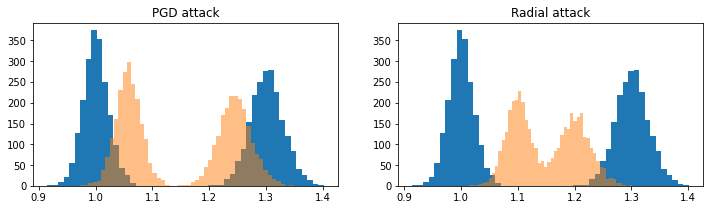

In [12]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_pgd"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"PGD attack");

plt.subplot(1, 2, 2)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_rad"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"Radial attack");

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

CPU times: user 8.07 s, sys: 586 ms, total: 8.65 s
Wall time: 8.1 s


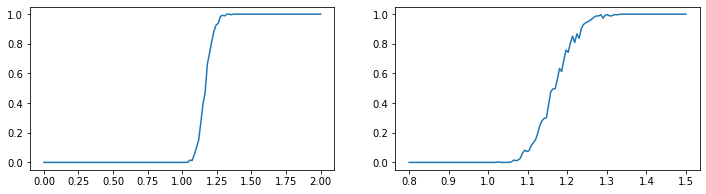

In [13]:
%%time
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
rads = np.linspace(start=0, stop=2, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

plt.subplot(1, 2, 2)
rads = np.linspace(start=0.8, stop=1.5, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

---

Norm $O(1)$, adversarial training, dim=1000, depth=2, width=1000

In [19]:
%%time
D = 1000
res = run_experiment_v2(
    dim=D, s0=1.0 / np.sqrt(D), s1=1.3 / np.sqrt(D),
    num_train=10 ** 4,
    learning_rate=3e-4,
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=256,
    train_epochs=24,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
    adv_train=True,
    adv_train_log_interval=2,
    seed=43
)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Finished epoch 0; acc=0.4805; val_accs=(0.0000, 1.0000); loss=0.7137206196784973
Finished epoch 2; acc=0.5000; val_accs=(0.0000, 0.9839); loss=0.6936509013175964
Finished epoch 4; acc=0.5017; val_accs=(0.0000, 0.9971); loss=0.6853422522544861
Finished epoch 6; acc=0.6841; val_accs=(0.1245, 0.4946); loss=0.6405535340309143
Finished epoch 8; acc=0.9932; val_accs=(0.1860, 0.3770); loss=0.3124054968357086
Finished epoch 10; acc=1.0000; val_accs=(0.4106, 0.2129); loss=0.04222817346453667
Finished epoch 12; acc=1.0000; val_accs=(0.4468, 0.1890); loss=0.011099914088845253
Finished epoch 14; acc=1.0000; val_accs=(0.4365, 0.1934); loss=0.005522341933101416
Finished epoch 16; acc=1.0000; val_accs=(0.4507, 0.1851); loss=0.0033228988759219646
Finished epoch 18; acc=1.0000; val_accs=(0.4565, 0.1812); loss=0.0022291867062449455
Finished epoch 20; acc=1.0000; val_accs=(0.4673, 0.1777); loss=0.001595327747054398
Finished epoch 22; acc=1.0000; val_accs=(0.4648, 0.1782); loss=0.0011938735842704773
Nat t

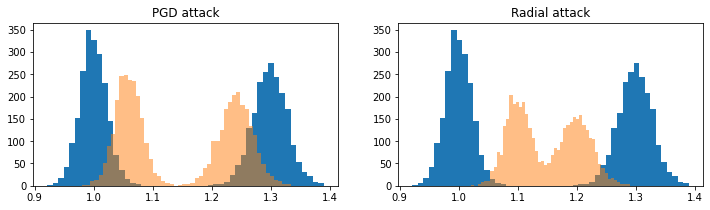

In [20]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_pgd"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"PGD attack");

plt.subplot(1, 2, 2)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_rad"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"Radial attack");

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

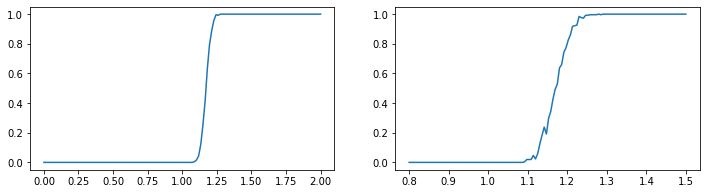

In [21]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
rads = np.linspace(start=0, stop=2, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

plt.subplot(1, 2, 2)
rads = np.linspace(start=0.8, stop=1.5, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

---

Norm $O(1)$, adversarial training, dim=1000, depth=2, width=5000

In [22]:
%%time
D = 1000
res = run_experiment_v2(
    dim=D, s0=1.0 / np.sqrt(D), s1=1.3 / np.sqrt(D),
    num_train=10 ** 4,
    learning_rate=3e-4,
    model_layers=[
        layers.Dense(5000, activation="relu"),
        layers.Dense(5000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=256,
    train_epochs=24,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
    adv_train=True,
    adv_train_log_interval=2,
    seed=43
)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Finished epoch 0; acc=0.4851; val_accs=(0.0000, 1.0000); loss=0.7000916004180908
Finished epoch 2; acc=0.5002; val_accs=(0.0000, 1.0000); loss=0.686064600944519
Finished epoch 4; acc=0.9816; val_accs=(0.3042, 0.7314); loss=0.233947291970253
Finished epoch 6; acc=1.0000; val_accs=(0.7905, 0.4219); loss=0.002371346578001976
Finished epoch 8; acc=1.0000; val_accs=(0.8066, 0.4429); loss=0.0007981070666573942
Finished epoch 10; acc=1.0000; val_accs=(0.8193, 0.4365); loss=0.0005093026557005942
Finished epoch 12; acc=1.0000; val_accs=(0.8247, 0.4297); loss=0.0003557389718480408
Finished epoch 14; acc=1.0000; val_accs=(0.8257, 0.4316); loss=0.00026105481083504856
Finished epoch 16; acc=1.0000; val_accs=(0.8281, 0.4272); loss=0.00019803058239631355
Finished epoch 18; acc=1.0000; val_accs=(0.8320, 0.4263); loss=0.00015383085701614618
Finished epoch 20; acc=1.0000; val_accs=(0.8359, 0.4224); loss=0.00012158788740634918
Finished epoch 22; acc=1.0000; val_accs=(0.8418, 0.4175); loss=9.7332544100936

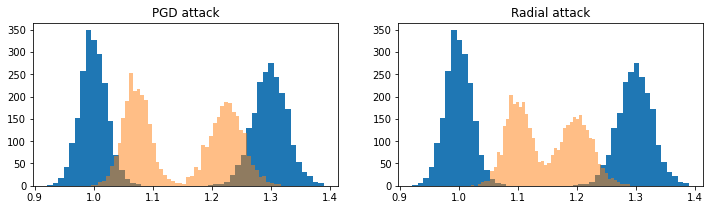

In [23]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_pgd"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"PGD attack");

plt.subplot(1, 2, 2)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_rad"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"Radial attack");

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

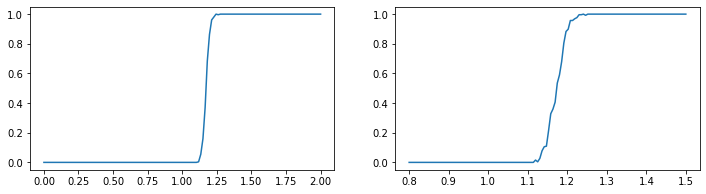

In [24]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
rads = np.linspace(start=0, stop=2, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

plt.subplot(1, 2, 2)
rads = np.linspace(start=0.8, stop=1.5, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

---

Norm $O(1)$, adversarial training, dim=1000, depth=5, width=1000

In [25]:
%%time
D = 1000
res = run_experiment_v2(
    dim=D, s0=1.0 / np.sqrt(D), s1=1.3 / np.sqrt(D),
    num_train=10 ** 4,
    learning_rate=3e-4,
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=256,
    train_epochs=24,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
    adv_train=True,
    adv_train_log_interval=2,
    seed=43
)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Finished epoch 0; acc=0.4566; val_accs=(1.0000, 0.0000); loss=0.6956767439842224
Finished epoch 2; acc=0.4934; val_accs=(1.0000, 0.0000); loss=0.693336546421051
Finished epoch 4; acc=0.5112; val_accs=(0.0000, 1.0000); loss=0.6925271153450012
Finished epoch 6; acc=0.7933; val_accs=(0.5723, 0.1289); loss=0.4575800895690918
Finished epoch 8; acc=0.9824; val_accs=(0.2163, 0.2778); loss=0.04805624857544899
Finished epoch 10; acc=0.9999; val_accs=(0.4204, 0.1826); loss=0.000749086553696543
Finished epoch 12; acc=1.0000; val_accs=(0.4536, 0.1748); loss=0.00013655093789566308
Finished epoch 14; acc=1.0000; val_accs=(0.4580, 0.1738); loss=5.559887722483836e-05
Finished epoch 16; acc=1.0000; val_accs=(0.4741, 0.1646); loss=1.790777787391562e-05
Finished epoch 18; acc=1.0000; val_accs=(0.4893, 0.1597); loss=5.667869572789641e-06
Finished epoch 20; acc=1.0000; val_accs=(0.4951, 0.1548); loss=1.947822966030799e-06
Finished epoch 22; acc=1.0000; val_accs=(0.5112, 0.1465); loss=8.281830901069043e-07


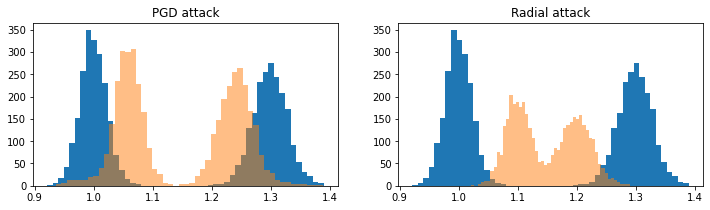

In [26]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_pgd"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"PGD attack");

plt.subplot(1, 2, 2)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_rad"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"Radial attack");

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

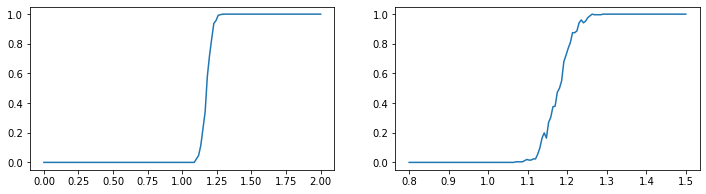

In [27]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
rads = np.linspace(start=0, stop=2, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

plt.subplot(1, 2, 2)
rads = np.linspace(start=0.8, stop=1.5, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

---

Norm $O(1)$, adversarial training, dim=1000, depth=5, width=5000

In [15]:
%%time
D = 1000
res = run_experiment_v2(
    dim=D, s0=1.0 / np.sqrt(D), s1=1.3 / np.sqrt(D),
    num_train=10 ** 4,
    learning_rate=3e-4,
    model_layers=[
        layers.Dense(5000, activation="relu"),
        layers.Dense(5000, activation="relu"),
        layers.Dense(5000, activation="relu"),
        layers.Dense(5000, activation="relu"),
        layers.Dense(5000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=256,
    train_epochs=24,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
    adv_train=True,
    adv_train_log_interval=2,
    seed=43
)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Finished epoch 0; acc=0.4818; val_accs=(0.0000, 1.0000); loss=0.6947371959686279
Finished epoch 2; acc=0.6563; val_accs=(0.1855, 0.9390); loss=0.6002393364906311
Finished epoch 4; acc=0.9761; val_accs=(0.5063, 0.6274); loss=0.06231646612286568
Finished epoch 6; acc=1.0000; val_accs=(0.6821, 0.5723); loss=0.0005449251038953662
Finished epoch 8; acc=1.0000; val_accs=(0.6924, 0.5898); loss=2.459340430505108e-05
Finished epoch 10; acc=1.0000; val_accs=(0.7568, 0.5244); loss=1.937881279445719e-06
Finished epoch 12; acc=1.0000; val_accs=(0.7544, 0.5312); loss=8.724082931621524e-07
Finished epoch 14; acc=1.0000; val_accs=(0.6660, 0.6250); loss=6.666145964118186e-07
Finished epoch 16; acc=1.0000; val_accs=(0.7441, 0.5479); loss=3.3048337400032324e-07
Finished epoch 18; acc=1.0000; val_accs=(0.7363, 0.5571); loss=2.2758243289899838e-07
Finished epoch 20; acc=1.0000; val_accs=(0.5967, 0.7002); loss=2.580758859949128e-07
Finished epoch 22; acc=1.0000; val_accs=(0.8140, 0.4556); loss=2.93279958896

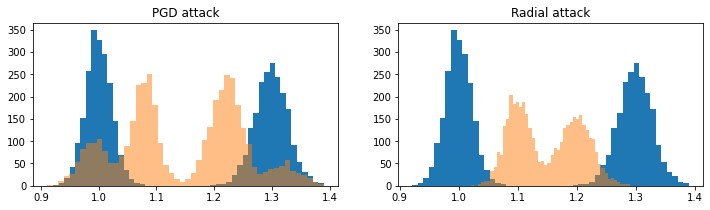

In [17]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_pgd"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"PGD attack");

plt.subplot(1, 2, 2)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_rad"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"Radial attack");

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

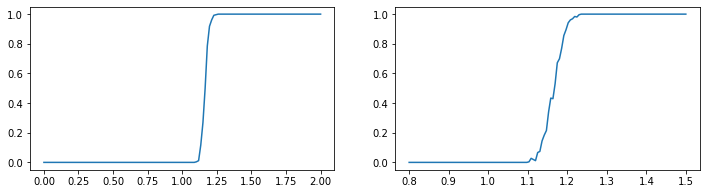

In [18]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
rads = np.linspace(start=0, stop=2, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

plt.subplot(1, 2, 2)
rads = np.linspace(start=0.8, stop=1.5, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

---

# Summary and conclusions

All experiments run with norm $O(1)$ in 1000 dimensions.

#### Table of results

| Setup | Nat train accs | Nat test accs | PGD train accs | PGD test accs | Rad train accs | Rad test accs |
| --- | --- | --- | --- | --- | --- | --- |
| n-train, w=1000, d=2 | (1.0000, 1.0000) | (0.9990, 0.9546) | (0.6209, 0.6091) | (0.1245, 0.0894) | (1.0000, 1.0000) | (0.8574, 0.6660) |
| n-train, w=5000, d=2 | (1.0000, 1.0000) | (1.0000, 0.9937) | (0.9995, 1.0000) | (0.4038, 0.2690) | (1.0000, 1.0000) | (0.9111, 0.7280) |
| n-train, w=10^4, d=2 | (1.0000, 1.0000) | (1.0000, 0.9893) | (0.9980, 0.9937) | (0.3838, 0.2681) | (1.0000, 1.0000) | (0.8940, 0.7222) |
| a-train, w=1000, d=2 | (1.0000, 1.0000) | (1.0000, 0.9985) | (1.0000, 1.0000) | (0.4629, 0.1758) | (1.0000, 1.0000) | (0.9673, 0.7319) |
| a-train, w=5000, d=2 | (1.0000, 1.0000) | (1.0000, 1.0000) | (1.0000, 1.0000) | (0.8413, 0.4180) | (1.0000, 1.0000) | (0.9878, 0.7686) |
| a-train, w=1000, d=5 | (1.0000, 1.0000) | (1.0000, 0.9971) | (1.0000, 1.0000) | (0.5005, 0.1523) | (1.0000, 1.0000) | (0.9678, 0.6831) |
| a-train, w=5000, d=5 | (1.0000, 1.0000) | (1.0000, 0.9995) | (1.0000, 1.0000) | (0.7690, 0.5029) | (1.0000, 1.0000) | (0.9712, 0.8203) |

Major observations:
1. PGD attack much more severe than the non-classifier dependent radius attack.
   This suggests that the vulnerability of the NN is not that transferable,
   and has more to due with the "noise" that the NN learns.
2. Adversarial training helps but does not give perfect robustness.
   Adversarial training really works better when the networks are wider.
   Suggest NTK might be well worth looking at.
3. Both natural training and adversarial training results in good natural accuracy.

Finally as a last note, sometimes training would not do anything.
This turned out to be a problem of too high learning rate.